# QMC Sequences with Random Rotation and Shift

This notebook demonstrates the `generate_with_transform()` method which allows generating
quasi-Monte Carlo (QMC) point patterns with random rotation and shift transformations.

**Key features:**
- Generate points in an expanded envelope region
- Apply random rotation and/or shift
- Clip to original window
- Works with Sobol', Halton, Latin Hypercube, and random sequences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from low_discrepancy_optimizer import LowDiscrepancyGenerator

# Set random seed for reproducibility
np.random.seed(42)

## 1. Basic Usage

Create a generator and use `generate_with_transform()` with different methods:

In [2]:
gen = LowDiscrepancyGenerator(d=2, minima=[0, 0], maxima=[1, 1])

# Generate Sobol' points with random transform
points, info = gen.generate_with_transform(n=100, method='sobol', return_info=True)

print(f"Method: {info['method']}")
print(f"Rotation angle: {np.degrees(info['angle']):.1f}°")
print(f"Shift vector: {info['shift']}")
print(f"Points generated: {info['n_generated']}, kept: {info['n_kept']}")

Method: sobol
Rotation angle: 134.8°
Shift vector: [0.09014286 0.04639879]
Points generated: 399, kept: 200


/Users/sergei/articles/design_ml/low_discrepancy_optimizer.py:192: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample_unit = sampler.random(n_generate)


## 2. Visual Comparison: Original vs Transformed

/Users/sergei/articles/design_ml/low_discrepancy_optimizer.py:32: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = sampler.random(n)


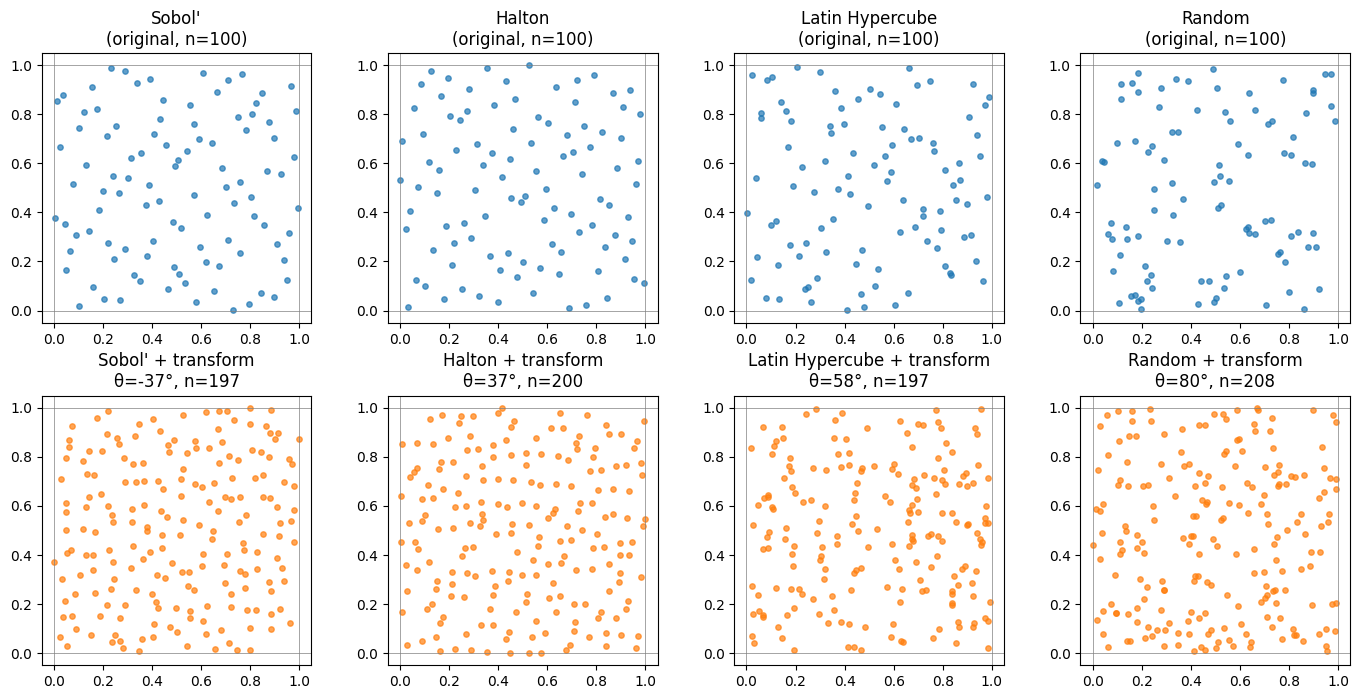

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

methods = ['sobol', 'halton', 'latin_hypercube', 'random']
titles = ["Sobol'", 'Halton', 'Latin Hypercube', 'Random']

# Row 1: Original (no transform)
for ax, method, title in zip(axes[0], methods, titles):
    if method == 'random':
        pts = gen.random(100)
    else:
        pts = getattr(gen, method)(100)
    ax.scatter(pts[:, 0], pts[:, 1], s=15, alpha=0.7)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_title(f'{title}\n(original, n={len(pts)})')
    for edge in [0, 1]:
        ax.axhline(edge, color='gray', linewidth=0.5)
        ax.axvline(edge, color='gray', linewidth=0.5)

# Row 2: With transform
for ax, method, title in zip(axes[1], methods, titles):
    pts, info = gen.generate_with_transform(n=100, method=method, return_info=True)
    ax.scatter(pts[:, 0], pts[:, 1], s=15, alpha=0.7, c='C1')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_title(f'{title} + transform\nθ={np.degrees(info["angle"]):.0f}°, n={len(pts)}')
    for edge in [0, 1]:
        ax.axhline(edge, color='gray', linewidth=0.5)
        ax.axvline(edge, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

## 3. Multiple Random Transforms of Sobol' Sequence

Each run produces a different rotation and shift:

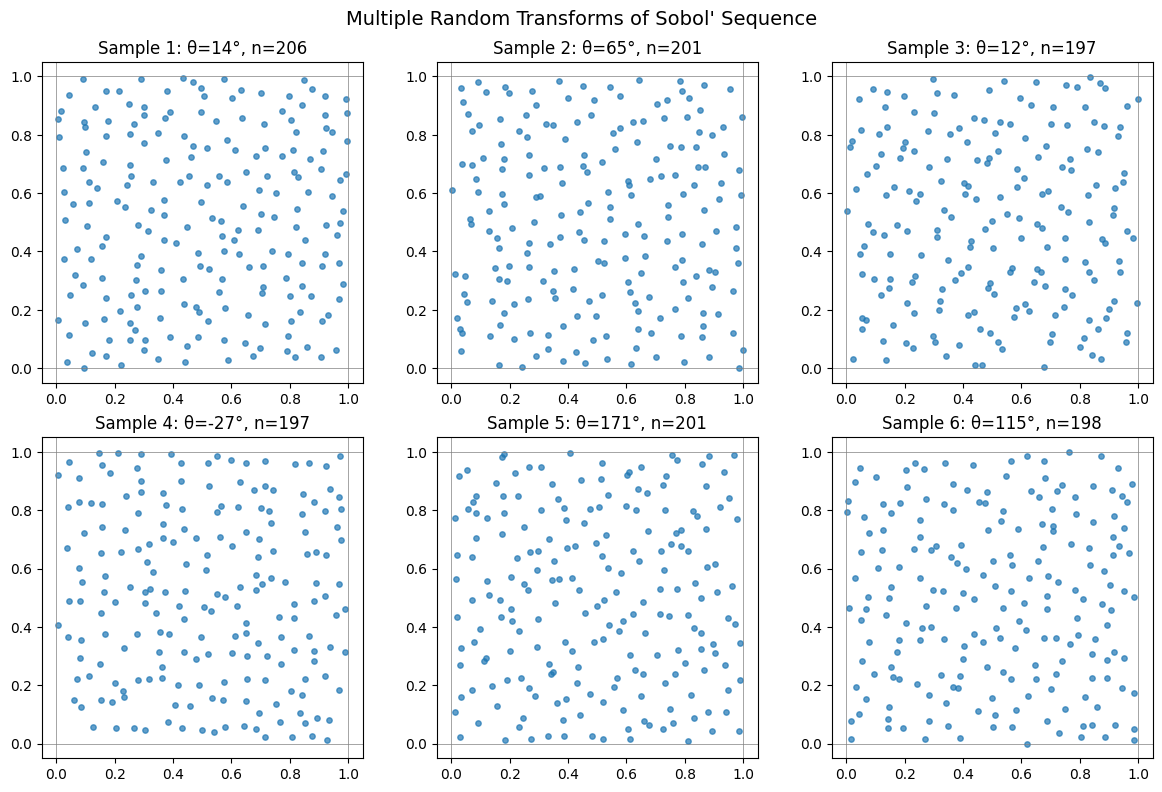

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    pts, info = gen.sobol_with_transform(n=100, return_info=True)
    ax.scatter(pts[:, 0], pts[:, 1], s=15, alpha=0.7)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_title(f'Sample {i+1}: θ={np.degrees(info["angle"]):.0f}°, n={len(pts)}')
    for edge in [0, 1]:
        ax.axhline(edge, color='gray', linewidth=0.5)
        ax.axvline(edge, color='gray', linewidth=0.5)

plt.suptitle("Multiple Random Transforms of Sobol' Sequence", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Fixed Rotation Angles

Demonstrate specific rotation angles (0°, 30°, 45°, 60°, 90°):

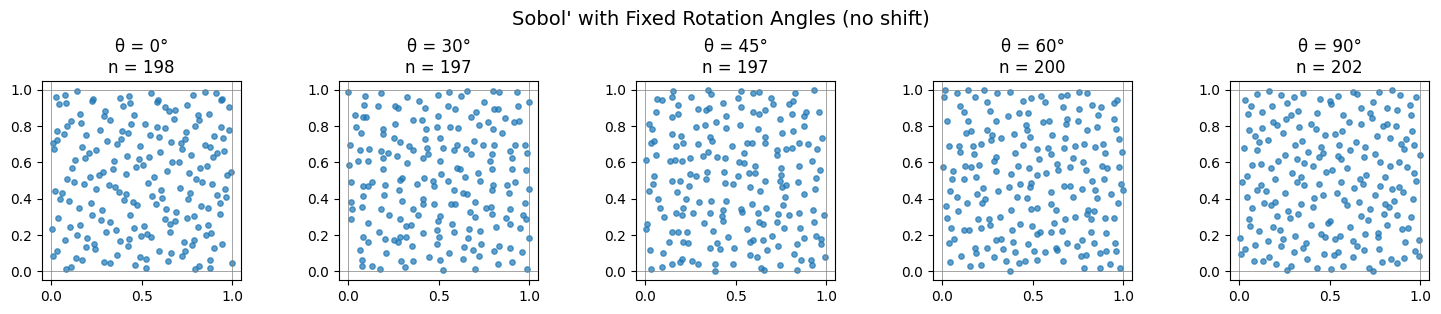

In [5]:
angles_deg = [0, 30, 45, 60, 90]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, angle_deg in zip(axes, angles_deg):
    angle_rad = np.radians(angle_deg)
    pts, info = gen.sobol_with_transform(n=100, angle=angle_rad, shift=[0, 0], return_info=True)
    ax.scatter(pts[:, 0], pts[:, 1], s=15, alpha=0.7)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_title(f'θ = {angle_deg}°\nn = {len(pts)}')
    for edge in [0, 1]:
        ax.axhline(edge, color='gray', linewidth=0.5)
        ax.axvline(edge, color='gray', linewidth=0.5)

plt.suptitle("Sobol' with Fixed Rotation Angles (no shift)", fontsize=14)
plt.tight_layout()
plt.show()

## 5. The Envelope Concept

Visualize how points are generated in an expanded envelope and then clipped:

/var/folders/p_/kd4r167n5hj66mtysm1dr7zc0000gn/T/ipykernel_7087/3932643453.py:10: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample_unit = sampler.random(n_gen)


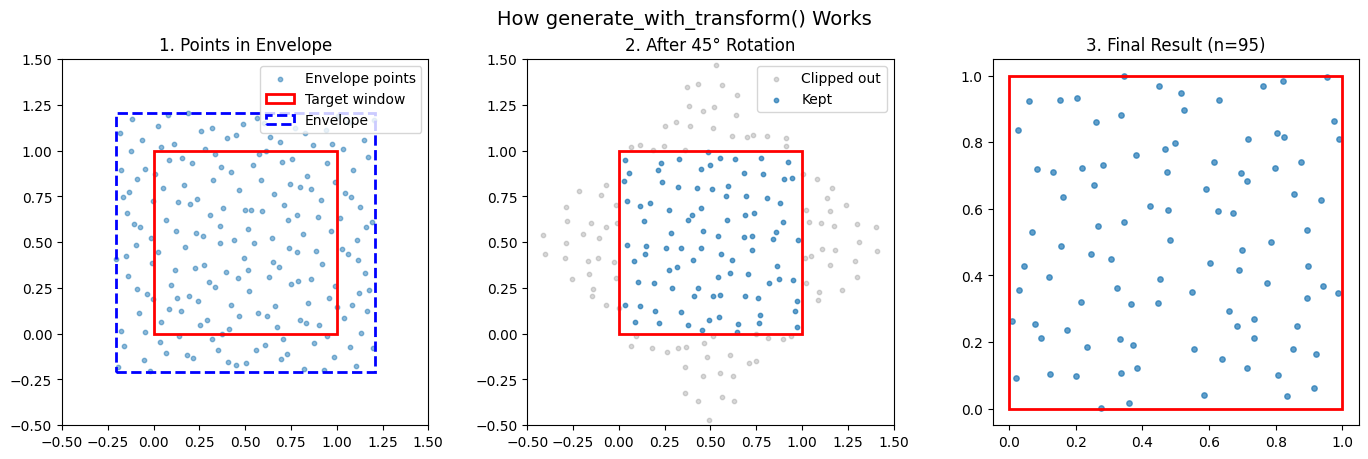

In [6]:
# Generate points and get transformation info
final_pts, info = gen.sobol_with_transform(n=64, angle=np.pi/4, shift=[0, 0], 
                                            oversample_factor=1.5, return_info=True)

# Also generate the envelope points (before clipping) for visualization
from scipy.stats import qmc
envelope_min, envelope_max = info['envelope_min'], info['envelope_max']
sampler = qmc.Sobol(d=2, scramble=True)
n_gen = info['n_generated']
sample_unit = sampler.random(n_gen)
envelope_pts = qmc.scale(sample_unit, envelope_min, envelope_max)

# Apply the same transform
center = np.array([0.5, 0.5])
R = info['rotation_matrix']
transformed_all = (envelope_pts - center) @ R.T + center

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

# 1. Envelope with original points
ax = axes[0]
ax.scatter(envelope_pts[:, 0], envelope_pts[:, 1], s=10, alpha=0.5, label='Envelope points')
rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=2, label='Target window')
ax.add_patch(rect)
env_rect = plt.Rectangle((envelope_min[0], envelope_min[1]), 
                          envelope_max[0]-envelope_min[0], envelope_max[1]-envelope_min[1],
                          fill=False, edgecolor='blue', linewidth=2, linestyle='--', label='Envelope')
ax.add_patch(env_rect)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.set_title('1. Points in Envelope')
ax.legend(loc='upper right')

# 2. After rotation
ax = axes[1]
mask = np.all((transformed_all >= 0) & (transformed_all <= 1), axis=1)
ax.scatter(transformed_all[~mask, 0], transformed_all[~mask, 1], s=10, alpha=0.3, c='gray', label='Clipped out')
ax.scatter(transformed_all[mask, 0], transformed_all[mask, 1], s=10, alpha=0.7, c='C0', label='Kept')
rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.set_title(f'2. After 45° Rotation')
ax.legend(loc='upper right')

# 3. Final clipped result
ax = axes[2]
ax.scatter(final_pts[:, 0], final_pts[:, 1], s=15, alpha=0.7)
rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.set_title(f'3. Final Result (n={len(final_pts)})')

plt.suptitle('How generate_with_transform() Works', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Non-Square Domain

The method works correctly with rectangular (non-square) domains:

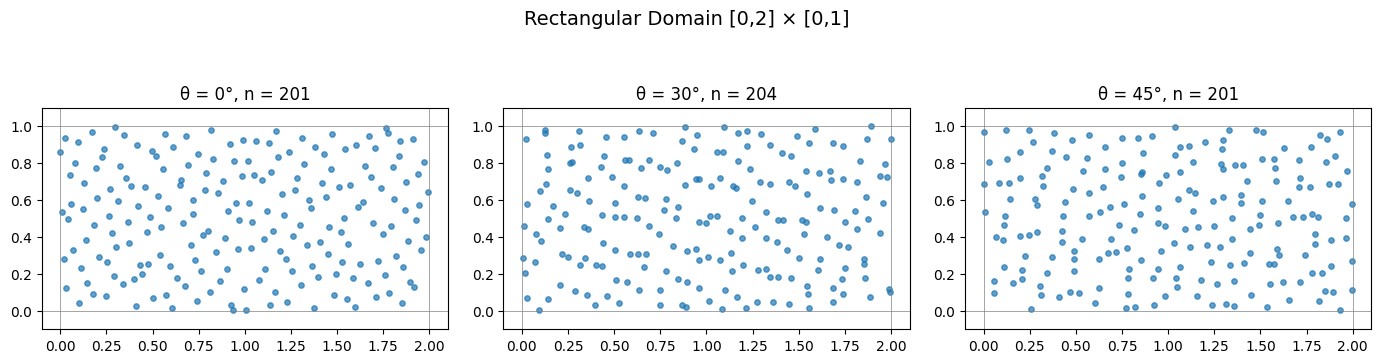

In [7]:
gen_rect = LowDiscrepancyGenerator(d=2, minima=[0, 0], maxima=[2, 1])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, angle_deg in zip(axes, [0, 30, 45]):
    pts, info = gen_rect.sobol_with_transform(n=100, angle=np.radians(angle_deg), 
                                               shift=[0, 0], return_info=True)
    ax.scatter(pts[:, 0], pts[:, 1], s=15, alpha=0.7)
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(f'θ = {angle_deg}°, n = {len(pts)}')
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axhline(1, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axvline(2, color='gray', linewidth=0.5)

plt.suptitle('Rectangular Domain [0,2] × [0,1]', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Convenience Aliases

For convenience, there are method-specific aliases:

In [8]:
# These are equivalent:
pts1 = gen.generate_with_transform(n=50, method='sobol')
pts2 = gen.sobol_with_transform(n=50)

pts3 = gen.generate_with_transform(n=50, method='halton')
pts4 = gen.halton_with_transform(n=50)

pts5 = gen.generate_with_transform(n=50, method='latin_hypercube')
pts6 = gen.latin_hypercube_with_transform(n=50)

pts7 = gen.generate_with_transform(n=50, method='random')
pts8 = gen.random_with_transform(n=50)

print("All convenience methods work correctly!")
print(f"sobol_with_transform: {len(pts2)} points")
print(f"halton_with_transform: {len(pts4)} points")
print(f"latin_hypercube_with_transform: {len(pts6)} points")
print(f"random_with_transform: {len(pts8)} points")

All convenience methods work correctly!
sobol_with_transform: 100 points
halton_with_transform: 99 points
latin_hypercube_with_transform: 99 points
random_with_transform: 105 points


## 8. Parameters Reference

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| `n` | int | required | Target number of points |
| `method` | str | 'sobol' | 'sobol', 'halton', 'latin_hypercube', or 'random' |
| `angle` | float/None | None | Rotation angle in radians (None = random) |
| `shift` | array/None | None | Shift vector (None = random, up to 10% of box) |
| `scramble` | bool | True | Use scrambled sequence |
| `oversample_factor` | float | 2.0 | Factor for oversampling |
| `return_info` | bool | False | Return transformation info dict |